# Transfer Learning with Tensorflow Part 2: Fine Tuning

In the previous notebook, we covered transfer learing feature extraction, now it's time to learn about new kind of transfer learning: fine tuning

## Creating helper functions

In previous notebooks, we've created a bunch of helper function, now we could rewrite them all, however, it's tedious.

So, t's a good idea to put function you'll want to use again in a script you can download and import into your notebook.

In [ ]:
!wget https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learing/main/Utils/helper_functions.py

--2021-08-08 13:30:45--  https://raw.githubusercontent.com/BaoLocPham/Tensorflow_Deep_Learing/main/Utils/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.11K  --.-KB/s    in 0s      

2021-08-08 13:30:45 (85.6 MB/s) - ‘helper_functions.py’ saved [10356/10356]



In [ ]:
# Import helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-08-08 13:30:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.7MB/s    in 4.0s    

2021-08-08 13:31:01 (39.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Checkout how many subdirectories and files in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Create training and testing directories path
train_10_percent_dir = "10_food_classes_10_percent/train"
test_10_percent_dir = "10_food_classes_10_percent/test"

This time we'll not using `ImageDataGenerator` but `image_dataset_from_directory`.

Why? Because it's faster and it's more handy than `ImageDataGenerator`

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE=32
IMG_SIZE=(224, 224)

train_data_10_percent = image_dataset_from_directory(train_10_percent_dir,labels="inferred",
                                          label_mode="categorical",
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE)

test_data_10_percent = image_dataset_from_directory(test_10_percent_dir,
                                                    label_mode="categorical",
                                                    batch_size=BATCH_SIZE,
                                                    image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
class_names = train_data_10_percent.class_names
class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

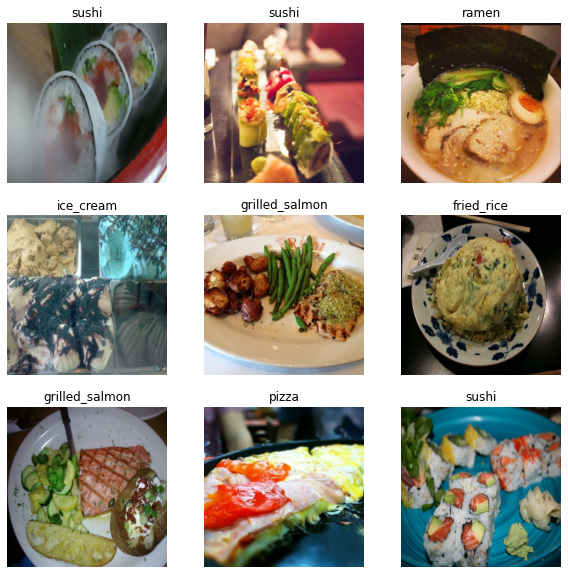

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for images, labels in train_data_10_percent.take(1):
  for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis(False)
plt.show()

## Model 0: Building a transfer learning model using the Keras Functional API 

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.applications 
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze th base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs but EfficientNetB0 doesn't
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model :{x.shape}")

# 6. Average pool the outputs of the base model (aggerate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_input_layer")(x)
print(f"Shape after GloablAveragePooling2D :{x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Compile the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs,name="model_0")

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model :(None, 7, 7, 1280)
Shape after GloablAveragePooling2D :(None, 1280)


In [ ]:
# 9. Compile the model
model_0.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# 10. Train the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25*len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210808-133114
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 46s 496ms/step - loss: 1.8294 - accuracy: 0.4453 - val_loss: 1.3208 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 8s 327ms/step - loss: 1.1021 - accuracy: 0.7453 - val_loss: 0.9224 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 8s 321ms/step - loss: 0.8336 - accuracy: 0.8067 - val_loss: 0.7577 - val_accuracy: 0.8059
Epoch 4/5
24/24 [==============================] - 9s 381ms/step - loss: 0.6808 - accuracy: 0.8293 - val_loss: 0.6869 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 9s 381ms/step - loss: 0.5914 - accuracy: 0.8640 - val_loss: 0.6264 - val_accuracy: 0.8289


In [ ]:
# Evaluate on full dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 15s 179ms/step - loss: 0.6095 - accuracy: 0.8312


[0.6095455884933472, 0.8312000036239624]

In [ ]:
# Check layers in our basemodel
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

# you can see the EfficentNetB0 has the rescaling and normalization layer already

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_input_layer ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


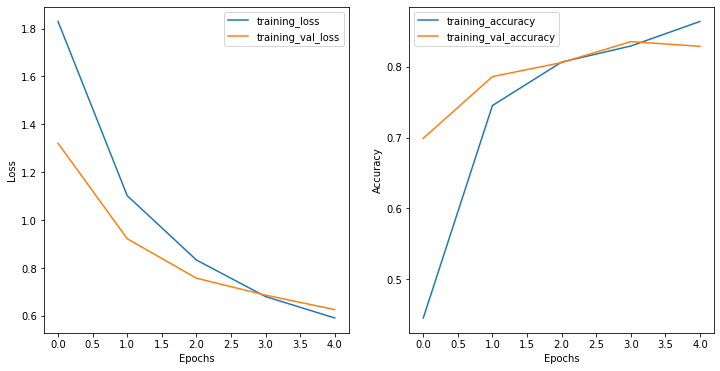

In [ ]:
# Checkout the training loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the `GlobalAveragePooling2D` layer
We have a tensor after our model goes through the `base_model` of shape (None,7,7,1280). But then it passed through `GlobalAveragePool2D`, it turns into (None,1280).

Let's use a similar tensor of shape (1,4,4,3) and then pass it to `GlobalAverageTensor2D`

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.uniform(shape=input_shape,minval=0, maxval=10)

In [ ]:
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[7.835211 , 0.3340423, 6.7973433],
         [2.891239 , 0.2023077, 9.858316 ],
         [3.353293 , 5.404969 , 7.341837 ],
         [6.717557 , 1.3046598, 3.900596 ]],

        [[9.407871 , 6.8446827, 4.535364 ],
         [5.0503674, 5.941161 , 2.612908 ],
         [5.8545065, 6.7110944, 1.8477619],
         [3.2818651, 7.0209217, 2.1270442]],

        [[4.6500516, 8.802357 , 7.8500104],
         [1.2401402, 8.489973 , 6.6548944],
         [0.6993258, 5.319666 , 4.063758 ],
         [2.3414552, 6.3958097, 6.741216 ]],

        [[3.3653653, 2.7354407, 6.3825274],
         [2.2862005, 5.963274 , 6.532731 ],
         [7.776352 , 6.7351055, 2.022456 ],
         [7.739562 , 5.4778633, 7.80357  ]]]], dtype=float32)>

In [ ]:
output_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [ ]:
output_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4.6556473, 5.230208 , 5.442021 ]], dtype=float32)>

In [ ]:
# Let's replicate the GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[4.6556473, 5.230208 , 5.442021 ]], dtype=float32)>

In [ ]:
np.mean(input_tensor[:,:,:,:1])

4.6556478

🛠 **Practice:** this time try to use `GlobalMaxPool2D()` 

In [ ]:
output_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)

In [ ]:
output_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.407871, 8.802357, 9.858316]], dtype=float32)>

In [ ]:
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.407871, 8.802357, 9.858316]], dtype=float32)>

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model in a particular sample, in our case, this is the output of the `tf.keras.layer.GlobalAveragePool2D()` layer) which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've have seen the incredible results transfer learning can get with only 10% of the training data, But how does it go with 1% of the training data... How about we set up a bunch of experiments to find out.

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

Note: throughout all experiments the same test dataset will be used to evaluate our model... This ensures consistency across evaluation metrics.

### Getting and preprocessing data for `model_1`

In [ ]:
# Download and unzip data - preprocess from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-08-08 13:32:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  40.7MB/s    in 3.1s    

2021-08-08 13:32:58 (40.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# create training and test_dirs
train_1_percent_dir = "10_food_classes_1_percent/train"
test_1_percent_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images we're working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_data_1_percent = image_dataset_from_directory(train_1_percent_dir,
                                                    label_mode="categorical",
                                                    image_size=IMG_SIZE,
                                                    batch_size=32) 

test_data_1_percent = image_dataset_from_directory(test_1_percent_dir,
                                                   label_mode="categorical",
                                                   image_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation 

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
  # , preprocessing.Rescaling(1./255) # this will need in model like ResNet but with EfficientNet don't
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)

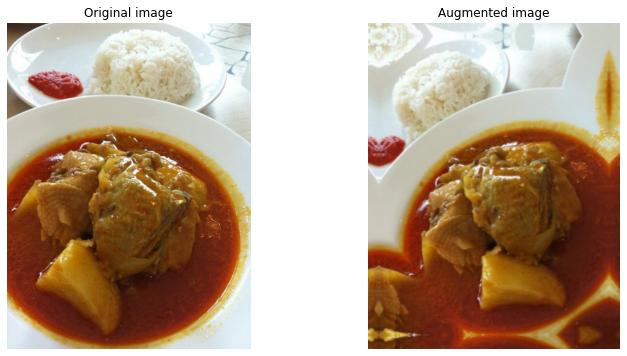

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read the random image
plt.figure(figsize=(12,6))
plt.title(target_class)

img = mpimg.imread(random_image_path)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original image")
plt.axis(False)

plt.subplot(1, 2, 2)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title("Augmented image")
plt.axis(False)

plt.show()
# print(random_image)

## Model 1: Feature extraction transfer learning on 1% of the training data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = IMG_SIZE+(3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model layers
base_model.trainable = False

# Create input_layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after the augmentation) and don't train it
x = base_model(x, training=False)

# Pool our features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make the model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

In [ ]:
# Compile the model
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data_1_percent,
                        validation_steps=int(0.25 * len(test_data_1_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/1_percent_feature_extraction/20210808-133304
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 16s 4s/step - loss: 2.2590 - accuracy: 0.1429 - val_loss: 2.1868 - val_accuracy: 0.1842
Epoch 2/5
3/3 [==============================] - 6s 3s/step - loss: 2.0525 - accuracy: 0.3143 - val_loss: 2.0911 - val_accuracy: 0.2484
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9233 - accuracy: 0.3286 - val_loss: 1.9682 - val_accuracy: 0.3454
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.6498 - accuracy: 0.5714 - val_loss: 1.8833 - val_accuracy: 0.3849
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5327 - accuracy: 0.7571 - val_loss: 1.7957 - val_accuracy: 0.4556


In [ ]:
# Evaluate on the full test set
model_1.evaluate(test_data_1_percent)

79/79 [==============================] - 14s 173ms/step - loss: 1.7834 - accuracy: 0.4756


[1.7833625078201294, 0.475600004196167]

> In the food 101 og papers: they reach 50.76% accuracy with 1000 images per class, but we beat their implementations model (`RandomForest`) with ~40% accuracy but on ly 7 images per class

In [ ]:
# Check out the model summary
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


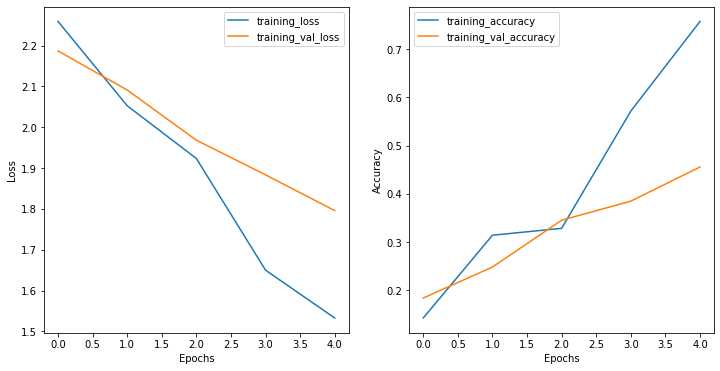

In [ ]:
# Plot the loss curves
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning on 10% of the training data with data augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_data_10_percent = image_dataset_from_directory(train_10_percent_dir,
                                                    label_mode="categorical",
                                                    image_size=IMG_SIZE,
                                                    batch_size=32) 

test_data_10_percent = image_dataset_from_directory(test_10_percent_dir,
                                                   label_mode="categorical",
                                                   image_size=IMG_SIZE,
                                                   batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
  # , preprocessing.Rescaling(1./255) # this will need in model like ResNet but with EfficientNet don't
], name="data_augmentation")

In [ ]:
input_shape = IMG_SIZE+(3,)

In [ ]:
# Set the input shape and base model, freezinng the base model layer
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False# Freeze the base model layers

# Create the inputs and outputs include the layers in between
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # data augmentations doesn't occur on test data
x = base_model(x, training=False) 
# pass augmented images to the base model but keep it in inference mode, 
#this ensures batchnorm layers don't get updated because base model has BatchNorm layer
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_2 = keras.Model(inputs, outputs)

In [ ]:
# compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is so useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_the_best_only=False,
                                                         save_freq="epoch", # Save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initital_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initital_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210808-133409
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 886ms/step - loss: 2.0102 - accuracy: 0.3427 - val_loss: 1.5245 - val_accuracy: 0.6086

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 16s 676ms/step - loss: 1.3934 - accuracy: 0.6560 - val_loss: 1.0642 - val_accuracy: 0.7582

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 17s 684ms/step - loss: 1.0575 - accuracy: 0.7413 - val_loss: 0.8602 - val_accuracy: 0.7895

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 17s 689ms/step - loss: 0.8952 - accuracy: 0.7587 - val_loss: 0.7617 - val_accuracy: 0.7944

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 16s 654ms/step - loss: 0.7909 - accuracy: 0.8107 - val_

In [ ]:
# Test model_2 on all test_data 
results_10_percent_data_aug = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 14s 172ms/step - loss: 0.7040 - accuracy: 0.8100


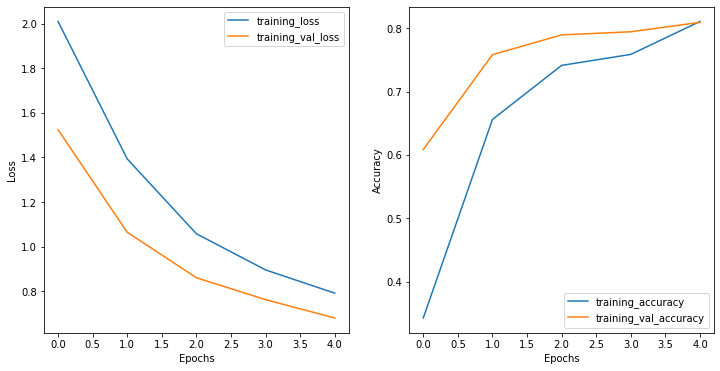

In [ ]:
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model+2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 9s 109ms/step - loss: 0.7023 - accuracy: 0.8144


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights 
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug, loaded_weights_model_results

([0.7023492455482483, 0.8144000172615051],
 [0.7023491859436035, 0.8144000172615051])

In [ ]:
# check to see if results are very close 
import numpy as np

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑 **Note:** Fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in (model_2.layers):
  print(f"{layer._name}, is trainable: {layer.trainable}")

input_layer, is trainable: True
data_augmentation, is trainable: True
efficientnetb0, is trainable: False
global_average_pooling_2D_layer, is trainable: True
output_layer, is trainable: True


In [ ]:
# What layers are in our base model
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# how many trainable variables are in our base model?
model_2.layers[2].summary(), len(model_2.trainable_variables)

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, None, None, 3 7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_2[0][0]            
_____________________________________________________________________________________

(None, 2)

In [ ]:
base_model.trainable = False

In [ ]:
# # To begin fine-tuning, let's start by setting last 10 layers of base_model.trainable = True 
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.0001), # When fine-tuning, you typically want to lower the learning rate for 10Xb
    metrics=["accuracy"]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>🔑 **Note:** When using fine-tuning it's best practice to lower your learing rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x the (though different sources will claim other values). A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)  

In [ ]:
len(model_2.trainable_variables) # from 2 trainables -> 2 + 10 = 10 trainables variables

12

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initital_epochs + 5

# Refit the model (same as model_2 except with more trainable variable)
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        validation_data=test_data_10_percent,
                        validation_steps=int(0.25 * len(test_data_10_percent)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_fine_tune_last_10")]) # start training from previous last epochs

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210808-133805
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 812ms/step - loss: 0.6916 - accuracy: 0.8080 - val_loss: 0.5328 - val_accuracy: 0.8339
Epoch 6/10
24/24 [==============================] - 16s 645ms/step - loss: 0.5310 - accuracy: 0.8440 - val_loss: 0.5316 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 16s 650ms/step - loss: 0.4617 - accuracy: 0.8747 - val_loss: 0.4840 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 16s 640ms/step - loss: 0.4346 - accuracy: 0.8640 - val_loss: 0.5218 - val_accuracy: 0.8240
Epoch 9/10
24/24 [==============================] - 14s 565ms/step - loss: 0.4020 - accuracy: 0.8893 - val_loss: 0.4739 - val_accuracy: 0.8306
Epoch 10/10
24/24 [==============================] - 13s 533ms/step - loss: 0.3660 - accuracy: 0.8933 - val_loss: 0.4867 - val_accuracy: 0.8388


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 14s 173ms/step - loss: 0.5052 - accuracy: 0.8276


In [ ]:
results_10_percent_data_aug

[0.703981339931488, 0.8100000023841858]

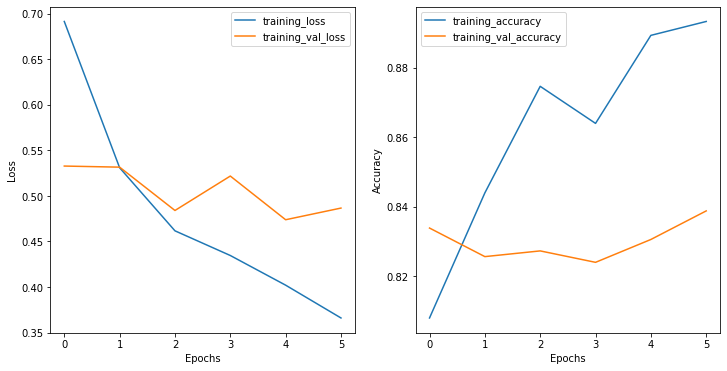

In [ ]:
# check out the loss curves of fine-tuned model
plot_loss_curves(history_3)

In [ ]:
# Let's create a function to compare training history
def compare_history(original_history, new_history, initital_epochs = 5):
  """
  Compare two TensorFlow history object.

  Args:
    original_history: the history before fine-tuning.
    new_history: the history after fine-tuning.
    initial_epochs: the epochs begin to fine-tuning.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Training val_acc")

  plt.plot([initital_epochs-1, initital_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Training val_loss")

  plt.plot([initital_epochs-1, initital_epochs-1], plt.ylim(), label="Start fine tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

  plt.show()



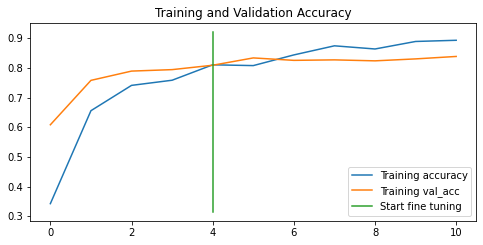

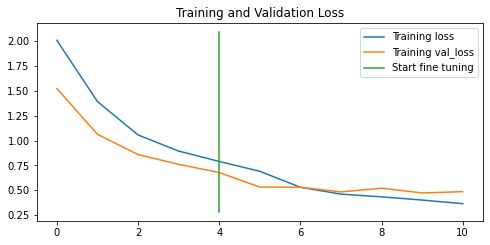

In [ ]:
compare_history(history_2, history_3, initital_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data 

In [ ]:
# download the 10 food classes all data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2021-08-08 13:42:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.184.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   132MB/s    in 4.7s    

2021-08-08 13:42:10 (105 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Set up training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images we're working now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [ ]:
# Set up data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test set is the same through out models

In [ ]:
# Evaluate the fine-tuned model (model_3 but actually model_2 fine-tuned)
model_2.evaluate(test_data)

79/79 [==============================] - 14s 173ms/step - loss: 0.5052 - accuracy: 0.8276


[0.5051888227462769, 0.8276000022888184]

In [ ]:
model_2.evaluate(test_data_10_percent)

79/79 [==============================] - 14s 173ms/step - loss: 0.5052 - accuracy: 0.8276


[0.5051887035369873, 0.8276000022888184]

To train a fine-tuning model (model 4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from check-point, 
#that way we can fine-tune from the same stage the 10 percent data model was fine-tunned from 
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evalute model_2 
model_2.evaluate(test_data)

79/79 [==============================] - 14s 171ms/step - loss: 0.7040 - accuracy: 0.8100


[0.7039812207221985, 0.8100000023841858]

In [ ]:
results_10_percent_data_aug

[0.703981339931488, 0.8100000023841858]

Alright, the previous steps might confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of data with data augmentation (`model_2`) and save model using `ModelCheckpoint()` callback.
2. Fine-tuned the same model (`model_2`) on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model **unfrozen** (`model_3`).
3. Save the results and training logs each time.
4. Reloaded the model from step 1 to do the same step as step 2 except this time we're going to use all of the data (`model_4`).



In [ ]:
# check which layers are turnable in the model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D_layer True
4 output_layer True


In [ ]:
# Let's drill into our base_model (EfficientNetB0) and see what layer are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# ReCompile 
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
fine_tune_epochs = initital_epochs + 5

history_4 = model_2.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch= history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210808-134419
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 79s 308ms/step - loss: 0.7272 - accuracy: 0.7699 - val_loss: 0.4680 - val_accuracy: 0.8470
Epoch 6/10
235/235 [==============================] - 90s 381ms/step - loss: 0.5825 - accuracy: 0.8081 - val_loss: 0.4259 - val_accuracy: 0.8651
Epoch 7/10
235/235 [==============================] - 82s 345ms/step - loss: 0.5241 - accuracy: 0.8316 - val_loss: 0.3783 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 82s 347ms/step - loss: 0.4774 - accuracy: 0.8457 - val_loss: 0.3573 - val_accuracy: 0.8865
Epoch 9/10
235/235 [==============================] - 75s 316ms/step - loss: 0.4351 - accuracy: 0.8544 - val_loss: 0.3341 - val_accuracy: 0.8947
Epoch 10/10
235/235 [==============================] - 69s 291ms/step - loss: 0.4065 - accuracy: 0.8716 - val_loss: 0.3579 - val_accuracy: 0.8931


In [ ]:
# Let's evaluate the fine-tuned model
model_2.evaluate(test_data)

79/79 [==============================] - 14s 172ms/step - loss: 0.3193 - accuracy: 0.8924


[0.3193168640136719, 0.8924000263214111]

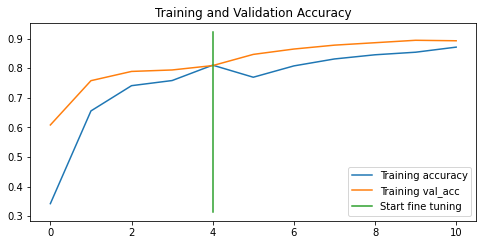

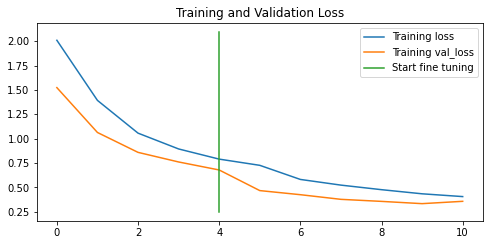

In [ ]:
# How did fine-tuning go with more data
compare_history(history_2, history_4)

## View our experiment data on TensorBoard

> 🔑 **Note:** anything you upload to TensorBoard.dev is going to be public.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should ~4 model)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning/ \
  --name "Transfer Learning Experiments with 10 food 101 classes" \
  --description "A series of different transfer learing experiments with variant amount of data and fine-tuning" \
  --one_shot # exits the uploader one it finish uploading

2021-08-08 08:41:59.665751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%

In [ ]:
!tensorboard dev list


2021-08-08 08:43:07.039277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
https://tensorboard.dev/experiment/68yTa3APSZmt6kgA1K6aJQ/
	Name                 Transfer Learning Experiments with 10 food 101 classes
	Description          A series of different transfer learing experiments with variant amount of data and fine-tuning
	Id                   68yTa3APSZmt6kgA1K6aJQ
	Created              2021-08-08 08:42:24 (49 seconds ago)
	Updated              2021-08-08 08:42:29 (44 seconds ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4221222
https://tensorboard.dev/experiment/xRYZEQYwQmy9baI1z65Ykg/
	Name                 EfficientNetB0 vs ResNet50v2
	Description          Comparing two different TF Hub extraction model architectures using 10% of the dataset
	Id                   xRYZEQYwQmy9baI1z65Ykg
	Created              2021-08-06 10:12:11
	Up

In [ ]:
# To delete an experiment
# !tensorboard dev delete --experiment_id `

# Extra curriculumn

### 1. Feature-extraction
Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [ ]:
# Data preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Create training and testing directories path
train_10_percent_dir = "10_food_classes_10_percent/train"
test_10_percent_dir = "10_food_classes_10_percent/test"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_data_10_percent = image_dataset_from_directory(train_10_percent_dir,
                                                  label_mode="categorical",
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_10_percent_dir,
                                      label_mode="categorical",
                                      image_size=IMG_SIZE,
                                      batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
input_shape = IMG_SIZE + (3,)
input_shape

(224, 224, 3)

In [ ]:
# 1. Create the base model (EfficientNetB0)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze the trainable
# 2. Create the input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
# 4. Create the rescaling layer (if using ResNet as base model)
# x = tf.keras.experimental.preprocessing.Rescaling(1./255)
# 5. Pass the inputs to the base model
x = base_model(inputs, training=False)
# 6. AveragePooling the outputs of the base_model layer (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_2D_layer")(x)
# 7. Create the outputs activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

extra_model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
extra_model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
for layer_number, layer in enumerate(extra_model_1.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 False
2 global_average_2D_layer True
3 output_layer True


In [ ]:
initital_epochs = 10

In [ ]:
# Set checkpoint path 
extra_checkpoint_path = "extra_curriculumn_1_weights/extra_model_1.cpkt"

extra_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(extra_checkpoint_path,
                                                               save_weights_only=True,
                                                               save_best_only=False,
                                                               save_freq="epoch",
                                                               verbose=1)

In [ ]:
# Fit the model aka feature extraction
extra_history_1 = extra_model_1.fit(train_data_10_percent,
                                    epochs=initital_epochs, # 10 epochs
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=int(0.25 * len(test_data)),
                                    callbacks=[extra_checkpoint_callback])

Epoch 1/10
24/24 [==============================] - 16s 398ms/step - loss: 1.8577 - accuracy: 0.4480 - val_loss: 1.2934 - val_accuracy: 0.7122

Epoch 00001: saving model to extra_curriculumn_1_weights/extra_model_1.cpkt
Epoch 2/10
24/24 [==============================] - 8s 325ms/step - loss: 1.0958 - accuracy: 0.7373 - val_loss: 0.9213 - val_accuracy: 0.7845

Epoch 00002: saving model to extra_curriculumn_1_weights/extra_model_1.cpkt
Epoch 3/10
24/24 [==============================] - 8s 324ms/step - loss: 0.7988 - accuracy: 0.8053 - val_loss: 0.7379 - val_accuracy: 0.8207

Epoch 00003: saving model to extra_curriculumn_1_weights/extra_model_1.cpkt
Epoch 4/10
24/24 [==============================] - 8s 327ms/step - loss: 0.6498 - accuracy: 0.8480 - val_loss: 0.6639 - val_accuracy: 0.8240

Epoch 00004: saving model to extra_curriculumn_1_weights/extra_model_1.cpkt
Epoch 5/10
24/24 [==============================] - 8s 325ms/step - loss: 0.5528 - accuracy: 0.8667 - val_loss: 0.6100 - va

### 2. Fine-tune last 20 layers

And train for more 10 epochs

In [ ]:
extra_model_2 = tf.keras.models.clone_model(extra_model_1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Compile the model
extra_model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
extra_model_2.evaluate(test_data) # accuracy is bad af because we clone model architecture not share weights

79/79 [==============================] - 18s 175ms/step - loss: 2.3026 - accuracy: 0.0984


[2.302583694458008, 0.09839999675750732]

In [ ]:
extra_model_2.load_weights(extra_checkpoint_path)

In [ ]:
extra_model_2.evaluate(test_data)

79/79 [==============================] - 17s 177ms/step - loss: 0.4987 - accuracy: 0.8516


[0.4987296760082245, 0.8515999913215637]

> This time we'll fine tuning last 20 layers and see how it does

In [ ]:
base_model.trainable=True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
for layer_number, layer in enumerate(extra_model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 efficientnetb0 True
2 global_average_2D_layer True
3 output_layer True


In [ ]:
# We have changed the base_model layer, let's recompile
extra_model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
# Fine-tuning for more 10 epochs
fine_tune_epochs = initital_epochs + 10

In [ ]:
extra_history_2 = extra_model_2.fit(train_data_10_percent,
                                    epochs=fine_tune_epochs,
                                    steps_per_epoch=len(train_data_10_percent),
                                    validation_data=test_data,
                                    validation_steps=int(0.25 * len(test_data)),
                                    initial_epoch=extra_history_1.epoch[-1])

Epoch 10/20
24/24 [==============================] - 17s 397ms/step - loss: 0.2919 - accuracy: 0.9573 - val_loss: 0.5128 - val_accuracy: 0.8388
Epoch 11/20
24/24 [==============================] - 8s 326ms/step - loss: 0.2858 - accuracy: 0.9600 - val_loss: 0.5024 - val_accuracy: 0.8520
Epoch 12/20
24/24 [==============================] - 8s 328ms/step - loss: 0.2812 - accuracy: 0.9613 - val_loss: 0.4917 - val_accuracy: 0.8536
Epoch 13/20
24/24 [==============================] - 8s 325ms/step - loss: 0.2771 - accuracy: 0.9653 - val_loss: 0.4736 - val_accuracy: 0.8569
Epoch 14/20
24/24 [==============================] - 8s 324ms/step - loss: 0.2731 - accuracy: 0.9653 - val_loss: 0.5009 - val_accuracy: 0.8503
Epoch 15/20
24/24 [==============================] - 8s 326ms/step - loss: 0.2691 - accuracy: 0.9653 - val_loss: 0.4815 - val_accuracy: 0.8618
Epoch 16/20
24/24 [==============================] - 8s 327ms/step - loss: 0.2655 - accuracy: 0.9653 - val_loss: 0.4816 - val_accuracy: 0.855

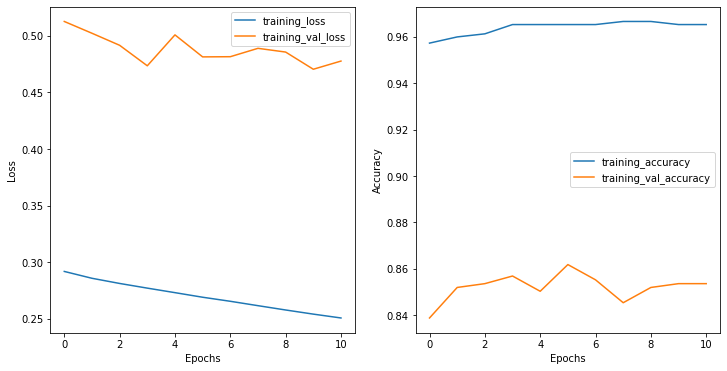

In [ ]:
plot_loss_curves(extra_history_2)

In [ ]:
def predict_random_image(dataset, model):
  """
  Choose a random image and then predict it
  """
  class_names = dataset.class_names
  plt.figure(figsize=(8,8))
  for images, labels in dataset.take(1):
    # Plot the random image
    rand_img = images[0]
    random_label = labels[0]
    rand_label = tf.argmax(random_label, axis=0)
    plt.imshow(rand_img.numpy().astype("uint8"))
    plt.title(class_names[rand_label])
    plt.axis(False)

    # Plot the prediction
    predict = model.predict(tf.expand_dims(rand_img, axis=0))
    pred = np.argmax(predict, axis=1)
    color =  "green" if pred[0] == rand_label else "red"
    plt.title(f"predicted: {class_names[pred[0]]}, right label is {class_names[rand_label]}", color=color)
    plt.show()


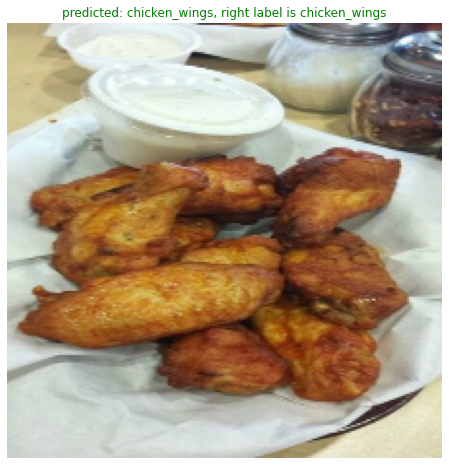

In [ ]:
predict_random_image(train_data_10_percent, extra_model_2)